# **APS1080: Introduction to Reinforcement Learning**
---

**Student Name:**

**Student ID:**

---

**Exercise 2:** Cart Pole preliminaries and Monte Carlo



In [4]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1

In [5]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [ ]:
!apt install xvfb

In [9]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay

In [10]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

Iterations that were run: 37


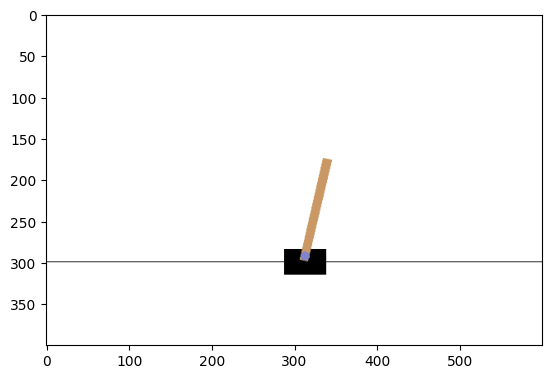

In [11]:
env = gym.make("CartPole-v0")
env.reset()
prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)

for i in range(50000):
  action = env.action_space.sample()
  print("step i",i,"action=",action)
  obs, reward, done, info = env.step(action)
  print("obs=",obs,"reward=",reward,"done=",done,"info=",info)
  screen = env.render(mode='rgb_array')

  plt.imshow(screen)
  ipythondisplay.clear_output(wait=True)
  ipythondisplay.display(plt.gcf())

  if done:
    break

ipythondisplay.clear_output(wait=True)
env.close()
print("Iterations that were run:",i)

----

# **Exercise 1:**

Can you design a dynamic programming based policy for the agent as in assignment 1? If so, design it and demonstrate that it solves the cart pole problem.

--

**Reasons DP is Not Suitable for CartPole:**

- CartPole has a continuous state space (cart position, cart velocity, pole angle, pole angular velocity), which DP typically cannot handle without discretization. Discretizing such a space would lead to an impractically large number of states.

- Discretizing a four-dimensional continuous space into a finite set of states would result in a massive state space, making computations infeasible and inefficient.

- While CartPole has a discrete action space (move left or right), combining it with a large, discretized state space exacerbates the computational challenges of DP.

- DP requires a complete model of the environment, including transition dynamics and rewards, to compute optimal value functions or policies. In reinforcement learning problems like CartPole, this model is typically not available or accessible.

- DP methods assume offline computation with full knowledge of the environment dynamics and state space. In contrast, CartPole and similar RL problems require online learning where agents interact with the environment to learn without complete knowledge of its dynamics.

Dynamic programming, due to its reliance on a discrete and known state space, is not suitable for solving CartPole directly. This is because dynamic programming requires an explicit model of the environment's transition dynamics, which describes how the state changes in response to actions. In the CartPole problem, the environment is continuous and often complex, making it difficult to define a precise model for these dynamics.


# **Exercise 2:**

Can you design a Monte Carlo based policy for the agent? What ingredients do you require? Explain the design flow, and execute it. Show that it works, or indicate why you can't proceed.

--

### **Monte Carlo-based Policy for CartPole Environment**

**What ingredients do you require?:**

- **Environment:** The CartPole environment from OpenAI Gym.
- **Policy:** policy specifying the probability distribution over actions given a state.
- **Sample Generation:** Generating episodes by following the policy and interacting with the environment.
- **Monte Carlo Estimation:** Estimating the value function using sampled episodes.
- **Policy Improvement:** Updating the policy based on the estimated value function.

--

**Explain the design flow, and execute it**


**Initialization:**

- The CartPole environment is initialized using Gym (gym.make('CartPole-v0')).
- A stochastic policy (epsilon_soft_policy) is defined, which is initially ε-soft (exploratory).
- The number of episodes (num_episodes) for policy evaluation is set.
- Data structures (Q and N) are initialized to store the action-value function (Q) and visitation counts.

**Episode Generation:**

- For each episode, the environment is reset (env.reset()) to get the initial state.
- Actions are chosen based on the ε-soft policy (epsilon_soft_policy) until the episode ends (done=True).
- States (episode_states), actions (episode_actions), and rewards (episode_rewards) are recorded during the episode.

**Monte Carlo Estimation (First-Visit MC):**

- After an episode ends, the return $G_t$ is calculated for each state-action pair from the first occurrence to the end of the episode.
- For each state-action pair, the Q-value is updated using the Monte Carlo incremental update rule: $𝑄(𝑆_𝑡,𝐴_𝑡)←𝑄(𝑆_𝑡,𝐴_𝑡)+𝛼(𝐺_𝑡−𝑄(𝑆_𝑡,𝐴_𝑡))$

where $𝛼$ is the learning rate.
Policy Improvement:

- The policy is updated to be greedy with respect to the updated Q-values: $π(s)=argmax_aQ(s,a)$

**Repeat:**

- Steps 2 to 4 are repeated for a number of episodes (num_episodes) until the policy converges or a sufficient number of episodes are completed.

In [50]:
import numpy as np
import gym
from collections import defaultdict

# Initialize environment
env = gym.make('CartPole-v0')

# Set random seed for reproducibility
np.random.seed(42)

# Define ε-soft policy parameters
epsilon = 0.1  # Exploration parameter
action_space_size = env.action_space.n  # Number of actions

# Initialize Q-values and visitation counts
Q = defaultdict(lambda: np.zeros(action_space_size))  # Q-function: defaultdict with initial values of zeros
N = defaultdict(lambda: np.zeros(action_space_size))  # Visit count: defaultdict with initial values of zeros

# Function to generate an ε-soft policy
def epsilon_soft_policy(state):
    state_tuple = tuple(state)  # Convert state to tuple for hashing
    probabilities = np.ones(action_space_size) * epsilon / action_space_size  # Initialize equal probabilities for each action
    best_action = np.argmax(Q[state_tuple])  # Get the best action based on Q-values
    probabilities[best_action] += 1.0 - epsilon  # Update the probability of the best action
    return np.random.choice(action_space_size, p=probabilities)  # Choose action based on probabilities

# Function to run on-policy first-visit MC control
def on_policy_first_visit_MC(env, num_episodes, gamma):
    total_iterations = 0  # Initialize total iterations counter
    for episode in range(num_episodes):
        episode_states = []  # List to store states in the current episode
        episode_actions = []  # List to store actions in the current episode
        episode_rewards = []  # List to store rewards in the current episode
        state = env.reset()  # Reset environment to start new episode and get initial state
        while True:
            action = epsilon_soft_policy(state)  # Choose action based on ε-soft policy
            next_state, reward, done, _ = env.step(action)  # Take action and observe next state and reward
            episode_states.append(state)  # Append current state to episode states
            episode_actions.append(action)  # Append chosen action to episode actions
            episode_rewards.append(reward)  # Append received reward to episode rewards
            state = next_state  # Update current state to next state
            if done:  # If episode is done (pole has fallen or max steps reached), exit loop
                break

        G = 0  # Initialize return (cumulative reward)
        # Loop backward through episode to calculate returns and update Q-values
        for t in range(len(episode_states) - 1, -1, -1):
            state = tuple(episode_states[t])  # Convert current state to tuple for hashing
            action = episode_actions[t]  # Get action at current time step
            reward = episode_rewards[t]  # Get reward at current time step
            G = gamma * G + reward  # Update return (cumulative reward)
            N[state][action] += 1  # Increment visitation count for state-action pair
            # Update Q-value using incremental update rule based on the return and visitation count
            Q[state][action] += (G - Q[state][action]) / N[state][action]
            pi_S_t = np.argmax(Q[state])  # Greedy policy improvement: Get the best action for the current state
            if action != pi_S_t:  # Check if action is not the best action
                break  # Exit loop if action is not optimal

        # Print Q-values after every 100 episodes
        if (episode + 1) % 100 == 0:
            print(f"Episode: {episode + 1}")
            for idx, (state, q_values) in enumerate(Q.items()):
                if idx < 3:  # Print Q-values for the first three states for brevity
                    print("Print Q-values for the first three states for brevity")
                    print(f"State: {state} Q-values: {q_values}")
            print()

        total_iterations += len(episode_states)  # Accumulate total iterations

# Run on-policy first-visit MC control
num_episodes = 1000  # Number of episodes
gamma = 1.0  # Discount factor

on_policy_first_visit_MC(env, num_episodes, gamma)  # Execute on-policy first-visit MC control


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns 

Episode: 100
Print Q-values for the first three states for brevity
State: (0.04755219, -0.0043567624, -0.049008306, 0.04283846) Q-values: [12.  0.]
Print Q-values for the first three states for brevity
State: (0.047465056, -0.19874294, -0.048151534, 0.31966496) Q-values: [ 0. 11.]
Print Q-values for the first three states for brevity
State: (0.043490198, -0.0029694792, -0.041758236, 0.012194062) Q-values: [10.  0.]

Episode: 200
Print Q-values for the first three states for brevity
State: (0.04755219, -0.0043567624, -0.049008306, 0.04283846) Q-values: [12.  0.]
Print Q-values for the first three states for brevity
State: (0.047465056, -0.19874294, -0.048151534, 0.31966496) Q-values: [ 0. 11.]
Print Q-values for the first three states for brevity
State: (0.043490198, -0.0029694792, -0.041758236, 0.012194062) Q-values: [10.  0.]

Episode: 300
Print Q-values for the first three states for brevity
State: (0.04755219, -0.0043567624, -0.049008306, 0.04283846) Q-values: [12.  0.]
Print Q-valu